In [4]:
import time
import board
import busio
import pandas as pd
from pandas import DataFrame
from matplotlib import pylab
import matplotlib.pyplot as plt
from pylab import *
import pylab
import numpy as np
import matplotlib.colors as clrs
import matplotlib.cm as cm
import matplotlib
from collections import deque
#matplotlib.use('TkAgg')
#%matplotlib notebook

#import time
import sys
import sqlite3
#from time import sleep

#import adafruit_ads1x15.ads1015 as ADS
import adafruit_ads1x15.ads1115 as ADS
from adafruit_ads1x15.analog_in import AnalogIn

import MySQLdb as db

HOST = "10.208.8.122"
PORT = 3306
USER = "yogi"
PASSWORD = "bittoo"
DB = "TemaccessToRemoteRp2"
'''
try:
    connection = db.Connection(host=HOST, port=PORT,
                               user=USER, passwd=PASSWORD, db=DB)

    c = connection.cursor()
    c.execute("SELECT * from temSensor")
    result = c.fetchall()
    for item in result:
        print (item)

except Exception as e:
    print (e)
'''
connectionL = db.connect(host="10.208.8.121",
                     user="yogi",
                     passwd="bittoo",
                     db="allSensors")

#c = conn.cursor()
connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)

cR = connectionR.cursor()
cL =connectionL.cursor()

i2c = busio.I2C(board.SCL, board.SDA)

# Create the ADC object using the I2C bus
ads = ADS.ADS1115(i2c)

ads.gain = 1


cL.execute('DROP TABLE IF EXISTS flowReadings;')
print ('table deleted')


cL.execute('CREATE TABLE flowReadings(id INT AUTO_INCREMENT PRIMARY KEY, ts TIMESTAMP DEFAULT CURRENT_TIMESTAMP, flowHP FLOAT, flowLoad FLOAT);')



lol=[[], [], []]
flowRateLoad  = []

def flatten(l_of_l):
    T = l_of_l[0]
    flattend_l = [val for sublist in T for val in sublist]
    #print ('flattened list is =', flattend_l)
    return flattend_l

def mct(Lol):
    mHP = Lol[2]
    T = flatten(Lol)
    mL = Lol[1]
    #this is density as polynomial function of T
    p_LperH = [999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 \
 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5 for x in T  ]

    #pV = [(999.8473664794213 + 6.29265190e-02*x[2] - 8.42930922e-03*x[2]**2 + 6.77190849e-05*x[2]**3 - 4.40840180e-07*x[2]**4 + 1.29302849e-09*x[2]**5)*2.7777e-07*y for x, y in zip(T, mHP)  ]
    # this is mass flow  in kg/S =  density*V(flow rate in m^3/sec)= d * (1000^-3/3600)
    mF_kgPerS =[ x*2.7777e-07*y for x, y in zip(p_LperH, mHP)]
    #this is Cp as functiono of T linear function
    cP_kjPerkgK = [4.253264761904763 - 0.00470305*b[2] for b in T]
    #mCT1 = sum([(4.253264761904763 - 0.00470305*b[2])*a*(b[2]-b[3]) for a, b in zip(mHP, T)])
    #mCT_kW = [(4.253264761904763 - 0.00470305*b[2])*a*(b[3]-b[4]) for a, b in zip(mHP, T)]
    #Cp*M*deltaT
    mCT_kW = [c*a*(b[3]-b[4]) for c, a, b in zip(cP_kjPerkgK,mF_kgPerS, T)]
    # sum(mct* 5/3600 (time stamp))  = kWh
    mCT2_kWh = sum([m*c*(dt[3]-dt[4])*0.0013888889 for m, c, dt in zip(mF_kgPerS,  cP_kjPerkgK, T)])
    #print (T[-1], mHP,'mCpDeltaT =', mCT)
    #print ('mCT is:',mCT)
    #print ('mF', mF_kgPerS, mHP[-1])
    #print (' mCT_kW is:', mCT_kW)
    #print ('mCTkWh is ',mCT2_kWh)
    return mCT_kW, mCT2_kWh

l_id = []

def idGenerator(Id, l_id):
    if Id not in l_id:
       l_id.append(Id) 
    #print (l_id)
    return l_id

#df_conc= None
def dfs(Lol):
    mHP = Lol[2]
    T = flatten(Lol)
    mL = Lol[1]
    StartTemTestingtank = [ 'id', 'dateTime', 'Tamb', 'TtopTestTankHPCir', 'TbottomTestTankHpCir', 'TtopSourceTank', \
'TloadTankMid','TTopTestTankLoadCir', 'TloadMix', 'TbottomSourceTank', 'TbottomTestTankLoadCir']
    l_T = ['T{}'.format(x) for x in range(0,10)]
    L = StartTemTestingtank +l_T
    df_mHP = DataFrame(mHP, columns=['flowHP'])
    df_mL = DataFrame(mL, columns=['flowLoad'])
    df_tem = DataFrame(T, columns = L)
    df_conc = pd.concat([df_tem, df_mHP, df_mL], axis=1)
    #print (df_mL)
    #print (df_mHP)
    #print (df_tem)
    #print (df_conc)
    return df_conc

def tankStrat(df):
    dfT = df.iloc[:, 11:-2]
    #print (dfT)
    return dfT
#tankStratTem = tankStrat(df_conc)


def create_color_step_obj(cmap_name, n):
    """
    Return scalarMap object with n colors in gradient from color map
    given in cmap_name.
    """
    cmap = plt.get_cmap(cmap_name)
    values = range(n)
    cNorm  = clrs.Normalize(vmin=values[0], vmax=values[-1])
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    return scalarMap



table deleted


small x is: 230
small y is : 0    40
1    42
2    47
3    34
4    38
5    35
6    31
7    20
8    43
9    26
Name: 99, dtype: int32


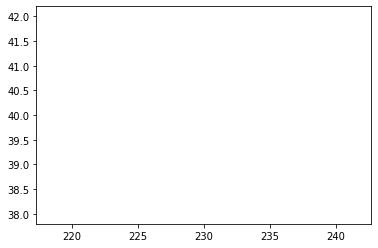

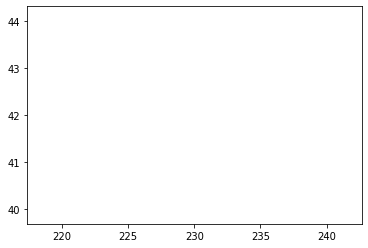

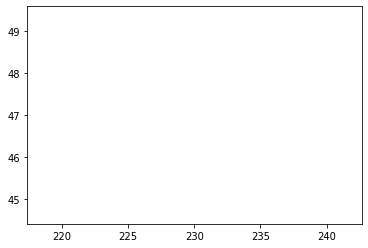

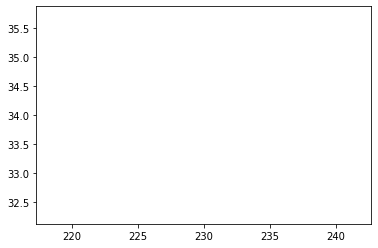

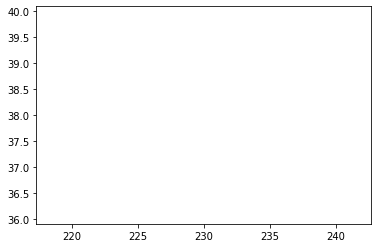

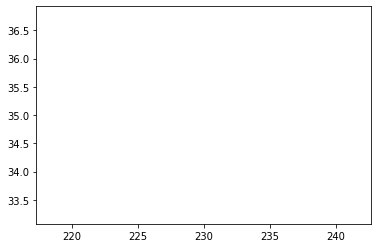

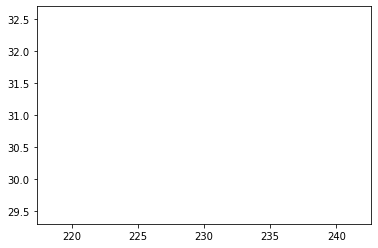

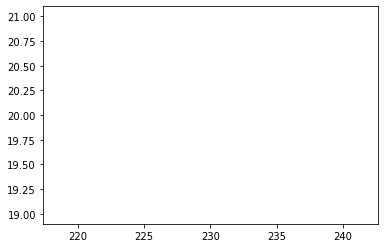

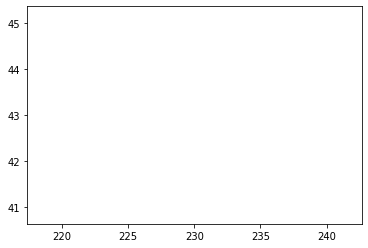

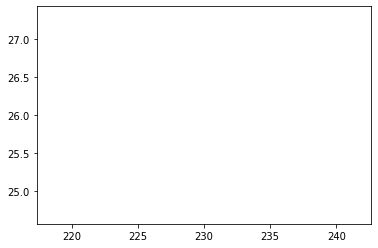

flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((12530, datetime.datetime(2021, 1, 18, 13, 37, 31), 20.3254, 26.9526, 21.17, 20.8321, 20.1903, 27.1896, 20.3592, 19.3122, 20.2241, 24.3475, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069
result is ((12530, datetime.datetime(2021, 1, 18, 13, 37, 31), 20.3254, 26.9526, 21.17, 20.8321, 20.1903, 27.1896, 20.3592, 19.3122, 20.2241, 24.3475, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12530, datetime.datetime(2021, 1, 18, 13, 37, 31), 20.3254, 26.9526, 21.17, 20.8321, 20.1903, 27.1896, 20.3592, 19.3122, 20.2241, 24.3475, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12530, datetime.datetime(2021, 1, 18, 13, 37, 31), 20.3254, 26.9526, 21.17, 20.8321, 20.1903, 27.1896, 20.3592, 19.3122, 20.2241, 24.3475, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12530, datetime.datetime(2021, 1, 18, 13, 37, 31), 20.3254, 26.9526, 21.17, 20.8321, 20.1903, 27.1896, 20.3592, 19.3122, 20.2241, 24.3475, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12530, datetime.datetime(2021, 1, 18, 13, 37, 31), 20.3254, 26.9526, 21.17, 20.8321, 20.1903, 27.1896, 20.3592, 19.3122, 20.2241, 24.3475, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12530, datetime.datetime(2021, 1, 18, 13, 37, 31), 20.3254, 26.9526, 21.17, 20.8321, 20.1903, 27.1896, 20.3592, 19.3122, 20.2241, 24.3475, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069
result is ((12531, datetime.datetime(2021, 1, 18, 13, 37, 33), 20.3254, 26.9865, 21.17, 20.8659, 20.1903, 27.1896, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12532, datetime.datetime(2021, 1, 18, 13, 37, 34), 20.3254, 26.9526, 21.2038, 20.8659, 20.2241, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.4683, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2573, 26.4111, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((12533, datetime.datetime(2021, 1, 18, 13, 37, 36), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.393, 19.3122, 20.2241, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.7989, 27.765, 27.2573, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12533, datetime.datetime(2021, 1, 18, 13, 37, 36), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.393, 19.3122, 20.2241, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.7989, 27.765, 27.2573, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((12533, datetime.datetime(2021, 1, 18, 13, 37, 36), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.393, 19.3122, 20.2241, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.7989, 27.765, 27.2573, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((12533, datetime.datetime(2021, 1, 18, 13, 37, 36), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.393, 19.3122, 20.2241, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.7989, 27.765, 27.2573, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12533, datetime.datetime(2021, 1, 18, 13, 37, 36), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.393, 19.3122, 20.2241, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.7989, 27.765, 27.2573, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12533, datetime.datetime(2021, 1, 18, 13, 37, 36), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.393, 19.3122, 20.2241, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.7989, 27.765, 27.2573, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((12533, datetime.datetime(2021, 1, 18, 13, 37, 36), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.393, 19.3122, 20.2241, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.7989, 27.765, 27.2573, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12533, datetime.datetime(2021, 1, 18, 13, 37, 36), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.393, 19.3122, 20.2241, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.7989, 27.765, 27.2573, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069
result is ((12533, datetime.datetime(2021, 1, 18, 13, 37, 36), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.393, 19.3122, 20.2241, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.7989, 27.765, 27.2573, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069
result is ((12533, datetime.datetime(2021, 1, 18, 13, 37, 36), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.393, 19.3122, 20.2241, 24.3813, 23.5021, 22.4542, 21.7782, 21.17, 27.7989, 27.765, 27.2573, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12534, datetime.datetime(2021, 1, 18, 13, 37, 38), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.3254, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12534, datetime.datetime(2021, 1, 18, 13, 37, 38), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.3254, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12534, datetime.datetime(2021, 1, 18, 13, 37, 38), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.3254, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12534, datetime.datetime(2021, 1, 18, 13, 37, 38), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.3254, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((12534, datetime.datetime(2021, 1, 18, 13, 37, 38), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.3254, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376
result is ((12534, datetime.datetime(2021, 1, 18, 13, 37, 38), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.3254, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((12534, datetime.datetime(2021, 1, 18, 13, 37, 38), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.3254, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12534, datetime.datetime(2021, 1, 18, 13, 37, 38), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.3254, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12534, datetime.datetime(2021, 1, 18, 13, 37, 38), 20.3254, 26.9526, 21.17, 20.8659, 20.1903, 27.1896, 20.3254, 19.3122, 20.1903, 24.3813, 23.5021, 22.4542, 21.7444, 21.1362, 27.765, 27.765, 27.2573, 26.3773, 25.4976),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12535, datetime.datetime(2021, 1, 18, 13, 37, 40), 20.3254, 26.9865, 21.2038, 20.8659, 20.1903, 27.1896, 20.3254, 19.2784, 20.2241, 24.3813, 23.5021, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((12535, datetime.datetime(2021, 1, 18, 13, 37, 40), 20.3254, 26.9865, 21.2038, 20.8659, 20.1903, 27.1896, 20.3254, 19.2784, 20.2241, 24.3813, 23.5021, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((12535, datetime.datetime(2021, 1, 18, 13, 37, 40), 20.3254, 26.9865, 21.2038, 20.8659, 20.1903, 27.1896, 20.3254, 19.2784, 20.2241, 24.3813, 23.5021, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238
result is ((12535, datetime.datetime(2021, 1, 18, 13, 37, 40), 20.3254, 26.9865, 21.2038, 20.8659, 20.1903, 27.1896, 20.3254, 19.2784, 20.2241, 24.3813, 23.5021, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12535, datetime.datetime(2021, 1, 18, 13, 37, 40), 20.3254, 26.9865, 21.2038, 20.8659, 20.1903, 27.1896, 20.3254, 19.2784, 20.2241, 24.3813, 23.5021, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681
result is ((12535, datetime.datetime(2021, 1, 18, 13, 37, 40), 20.3254, 26.9865, 21.2038, 20.8659, 20.1903, 27.1896, 20.3254, 19.2784, 20.2241, 24.3813, 23.5021, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544
result is ((12535, datetime.datetime(2021, 1, 18, 13, 37, 40), 20.3254, 26.9865, 21.2038, 20.8659, 20.1903, 27.1896, 20.3254, 19.2784, 20.2241, 24.3813, 23.5021, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12535, datetime.datetime(2021, 1, 18, 13, 37, 40), 20.3254, 26.9865, 21.2038, 20.8659, 20.1903, 27.1896, 20.3254, 19.2784, 20.2241, 24.3813, 23.5021, 22.4204, 21.7444, 21.17, 27.765, 27.765, 27.2911, 26.3773, 25.5314),)


<Figure size 432x288 with 0 Axes>

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134
result is ((12536, datetime.datetime(2021, 1, 18, 13, 37, 41), 20.3254, 26.9865, 21.17, 20.8321, 20.1903, 27.1557, 20.3592, 19.3122, 20.1903, 24.3813, 23.5021, 22.4204, 21.7444, 21.17, 27.7989, 27.765, 27.2573, 26.4111, 25.5314),)


KeyboardInterrupt: 

In [19]:
#This works plots interactivly but index dosent changes. So i need to yield the x and y values from generators

def plotObject(df,alpha =0.7):

    #plt.ion()
    #fig, ax = plt.ion()
    #ax.set_xlabel('Index')
    #ax.set_ylabel('Tem, C', color='r')
    #plt.legend (bbox_to_anchor=(1.4,0.89), fontsize='xx-small', loc='upper right', ncol=2)
    for i in range (0, 10):
        x = df.index[-1]
        y =df.iloc[-1]
        #print ('dataframe is :',df)
        Fig = ax.plot(x, y.iloc[i], label = 'Layer ' + str(10-i), color= scm.to_rgba(10-i, alpha))
    #plt.show()
    #plt.draw()
    #plt.pause(0.05)
    return Fig

#tankStrat(dfs(lol))
cmap_name = "jet"
scm = create_color_step_obj(cmap_name, 10)
#plt.ion()
#fig, ax = plt.subplots()
#plt.legend (bbox_to_anchor=(1.4,0.89), fontsize='xx-small', loc='upper right', ncol=2)
#plt.draw()
#plt.pause(0.05)
#x = np.random.random()
x = 230
#x = pd.DataFrame(np.zeros(1))
print ('small x is:',x)
y = pd.DataFrame(np.random.randint(20,60,size=(100, 10))).iloc[-1]
#y = pd.DataFrame(np.Nan(0,100,size=(100, 10))).iloc[-1]
#y = pd.DataFrame([0]*10)
print ('small y is :', y)
#fig = [plt.plot(x, y.iloc[i], label = 'Layer ' + str(10-i), color= scm.to_rgba(10-i, 0.7)) for i in range (0,10)]
#plt.figure(figsize=(10,8))
plt.ion()
#plt.figure()
#plt.ion()
fig = plt.figure()
axes = fig.add_subplot(111)
#plt.axis([0,1000,0,1])
x = x
for i in range(0, 10):
    Y = y.iloc[i]
    
    #Y = y.iloc[i]
    line_list = [plt.plot(x, Y, label = 'Layer ' + str(10-i), color= scm.to_rgba(10-i, 0.7)) for i in range (0, 10)]
    #plt.ion()
    plt.draw()
    #time.sleep(0.1)
    plt.pause(0.0001)  
    plt.show()
    ##plt.pause(0.01)

def plotInnerFig(figs, df):
    for fi in figs:
        fi.set_ydata(df)
        plt.draw()
        plt.pause(0.5)
        plt.show()
    return 

def plot(df, fig):
    x = df.index
    y = df
    Fig = [fi.set_ydata(df) for fi in fig]
        
    plt.draw()
    plt.pause(0.5)
    plt.show()
    return Fig

while True:
    #c.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(?,?,?,?)", (chan2.voltage, chan1.voltage))
    #connection.commit()
    chan1 = AnalogIn(ads, ADS.P0)
    chan2 = AnalogIn(ads, ADS.P1)

    chan1Vol = chan1.voltage
    chan1curr = chan1Vol/159.42

    chan2Vol = chan2.voltage
    chan2curr=chan2Vol/159.65
    #flow1 = ((chan1Vol/159.42)*1000 -4)/16*1000
    flow1 = ((chan1Vol/159.42)-0.003956)/0.0000159
    #flow2 = ((chan2Vol/159.65)*1000 -4)/16*4000 +20
    #flow2 = ((chan2Vol/159.65)- 0.0005468893873066417)/1.09561608e-05
    flow2 = ((chan2Vol/159.65)- 0.003973767754877122)/5.3038815e-06
    cL.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(%s, %s)", (flow2, flow1))
    connectionL.commit()
    #print('flow HP:',"{:>5}\t{:>5.3f}".format(chan2.value, chan2.voltage), '\n\n')
    #print('flow load:',"{:>5}\t{:>5.3f}".format(chan1.value, chan1.voltage, '\n\n'))
    print('flow rates load is = ',chan1Vol, chan1curr,flow1 )
    print('flow rates HP is = ',chan2Vol, chan2curr,flow2 )

    connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)
    cR = connectionR.cursor()
    #c.execute("SELECT * from temSensor")
    cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    #result = cR.fetchall()
    print ('result is',result)
    id = result[0][0]
    idGenerator(id, l_id)
    #print ('id is :', id)
    flowRateLoad.append(flow1)

    if lol[0] ==[] or id < lol[0][-1][0][0] :
        lol[0].append(result)
        #print (lol)
        lol[1].append(flow1)
        lol[2].append(flow2)
    elif lol[0] != [] and id > lol[0][-1][0][0]:

        lol[0].append(result)
        lol[1].append(flow1)
        lol[2].append(flow2)


    mct(lol)
    #print ('lol is:',lol)
    #dfs(lol)
    #tankStrat(dfs(lol))
    #plot(tankStrat(dfs(lol)), plotObject(tankStrat(dfs(lol))))
    #plotObject(tankStrat(dfs(lol)))for i in range (0, 10):
    x = tankStrat(dfs(lol)).index[-1]
    y =tankStrat(dfs(lol)).iloc[-1]
    print ('x is:',x,'y is :',y)
    '''
    for line in line_list:
        print (type(line), line)
        #for li in line:
        line.set_xdata(x)
        line.set_ydata(y)
    axes.autoscale_view(True,True,True)
    '''
    
    for line in line_list:
        for li in line:
            li.set_xdata(x)
            li.set_ydata(y)
        plt.show()
        plt.draw()
        plt.pause(0.0001)
    
        
        
    #plt.figure()
    #for f in fig:
    #    f.set_xdata(x)
    #    f.set_ydata(y)
    #plt.show()
    #plt.draw()
    #plt.pause(0.01)
    #print('x is ',x, 'y is:', y)
    #plt.draw()
    #plt.pause(0.05)
    #print ('dataframe is :',df)
    
    
    
    print('________________________________________________________________')
    time.sleep(0.05)

No handles with labels found to put in legend.


flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


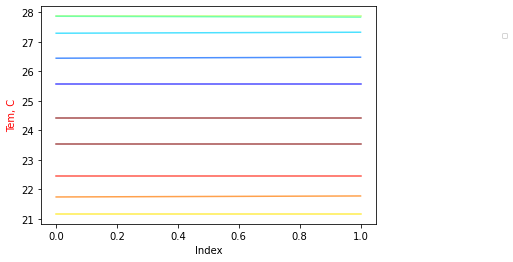

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


No handles with labels found to put in legend.


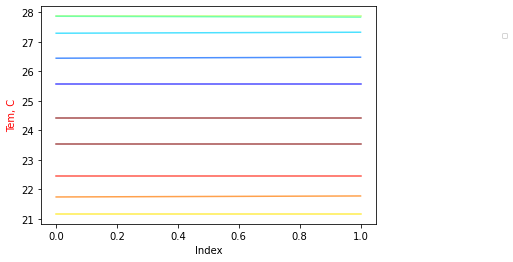

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


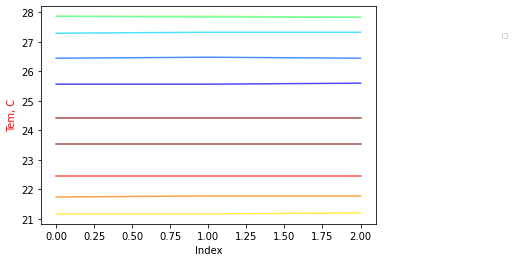

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


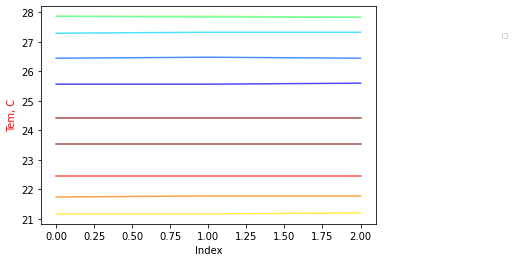

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238


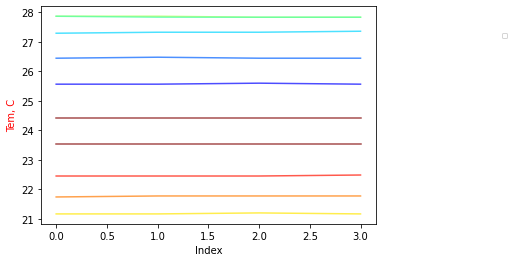

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


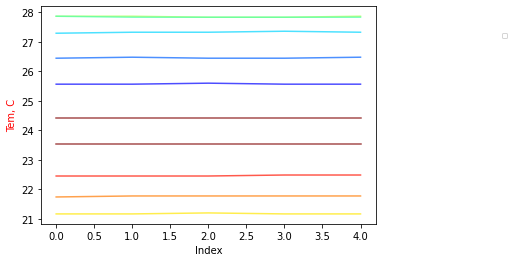

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


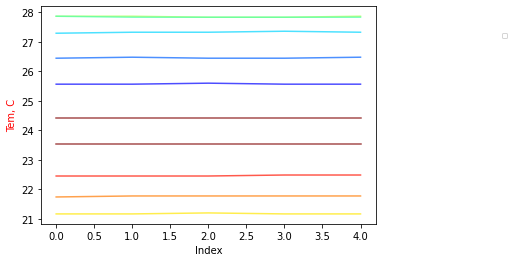

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


No handles with labels found to put in legend.


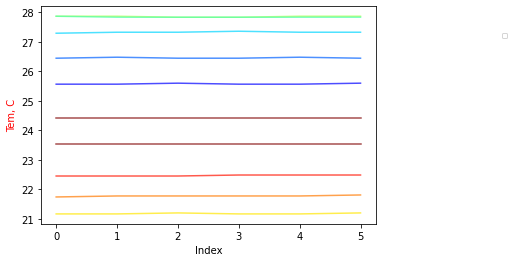

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


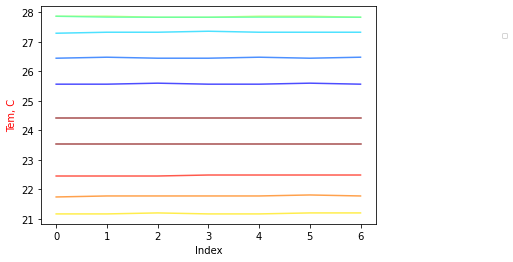

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


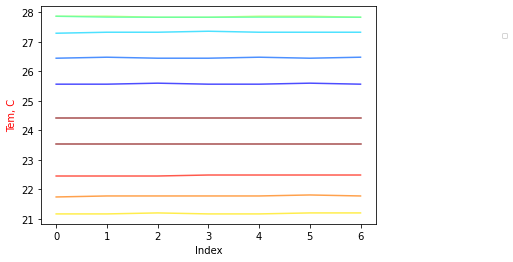

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


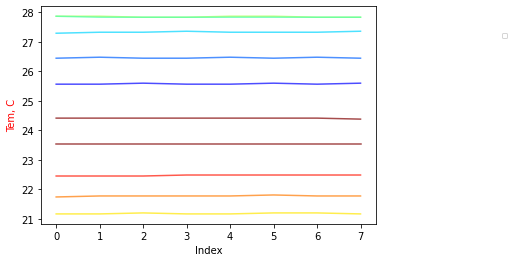

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


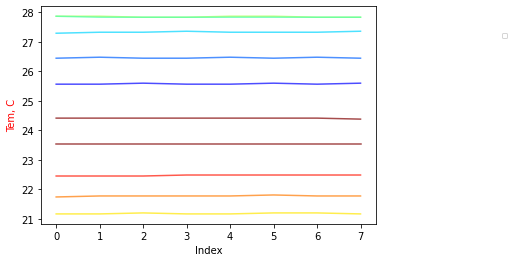

________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544


No handles with labels found to put in legend.


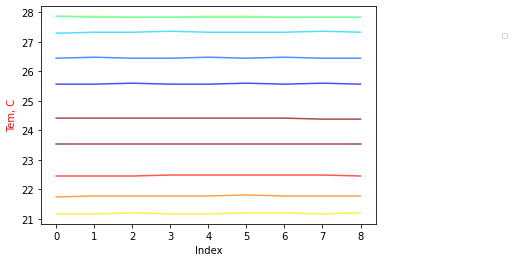

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238


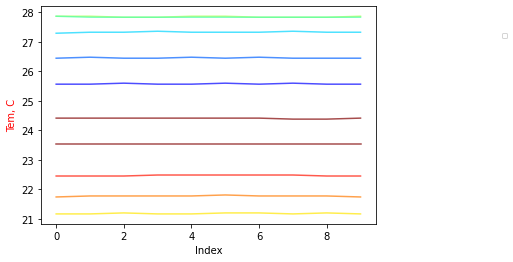

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


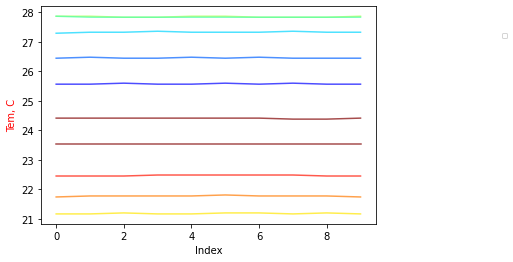

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544


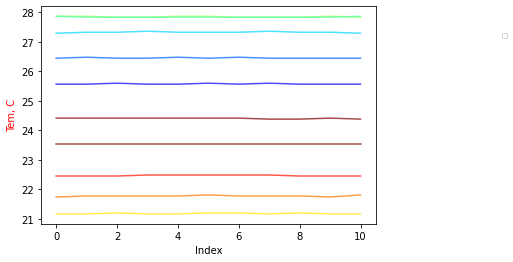

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


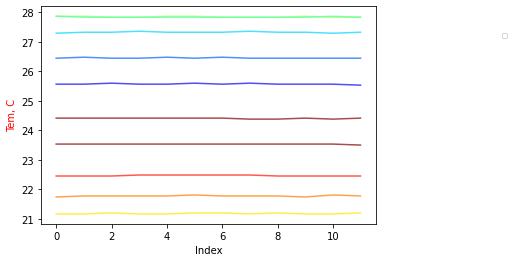

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


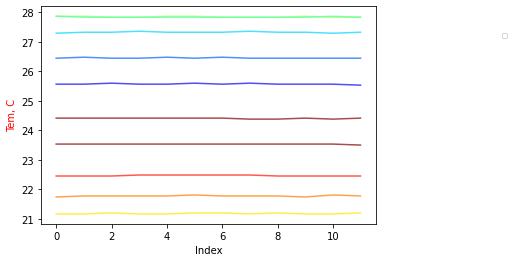

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238


No handles with labels found to put in legend.


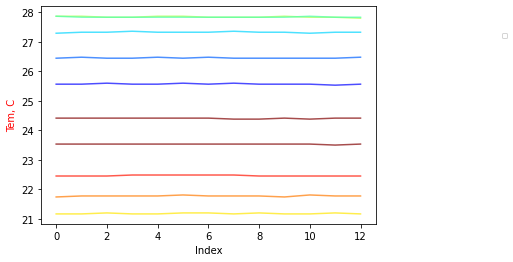

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


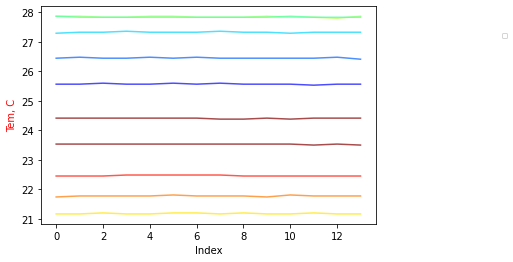

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


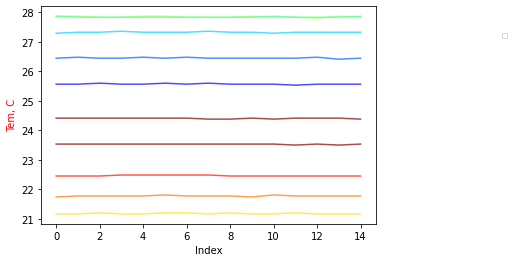

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


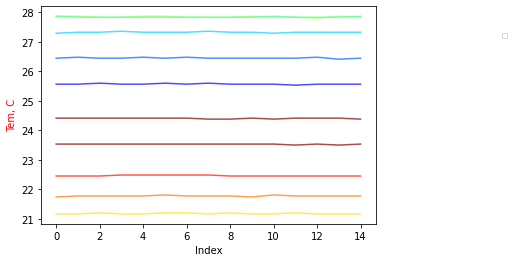

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


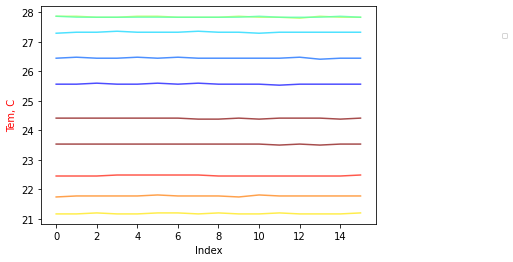

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069


No handles with labels found to put in legend.


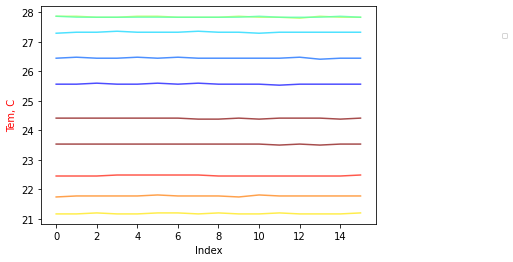

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


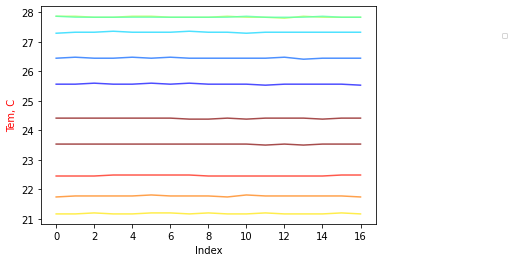

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069


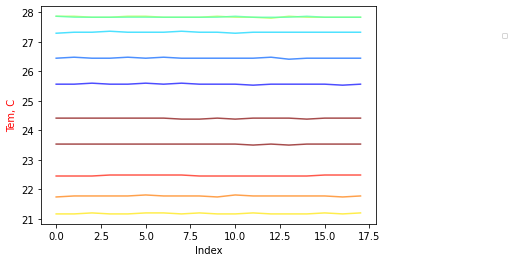

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238


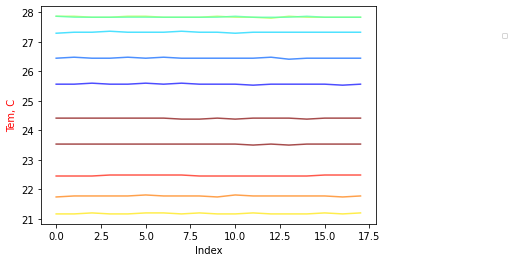

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


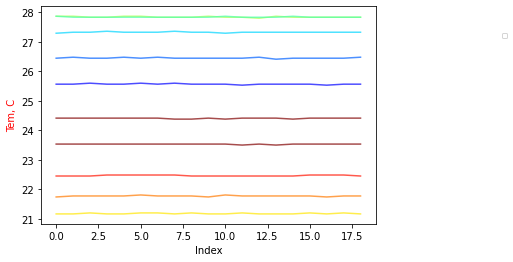

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


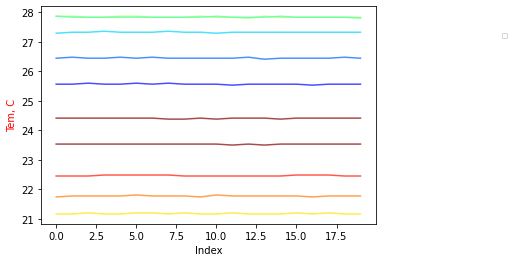

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


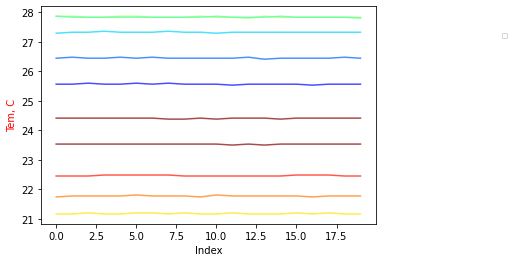

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


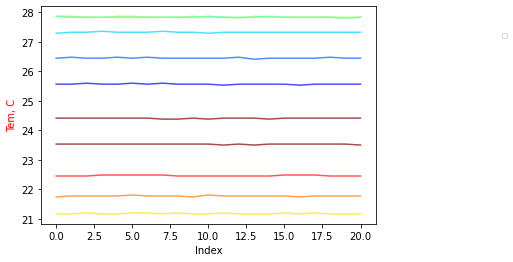

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


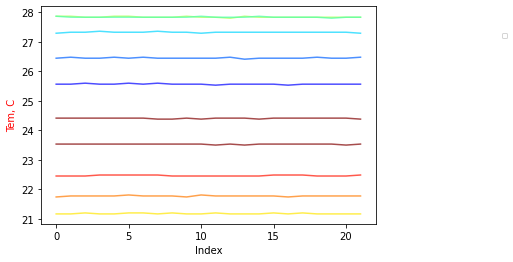

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


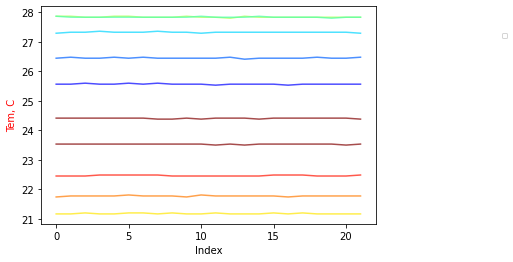

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


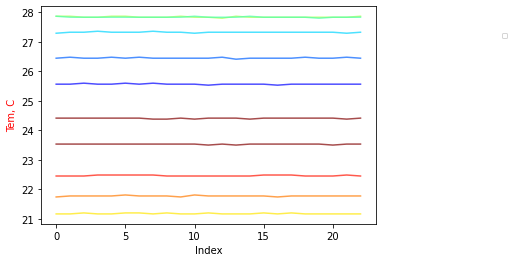

________________________________________________________________
flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


No handles with labels found to put in legend.


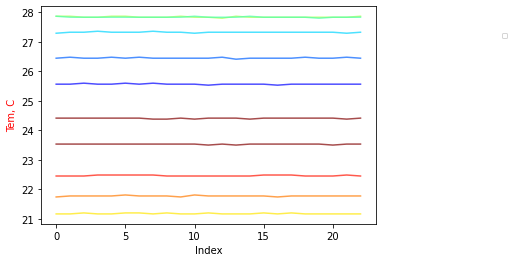

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


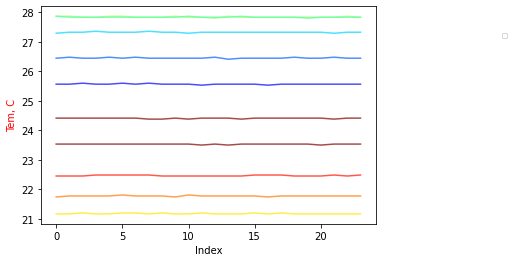

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238


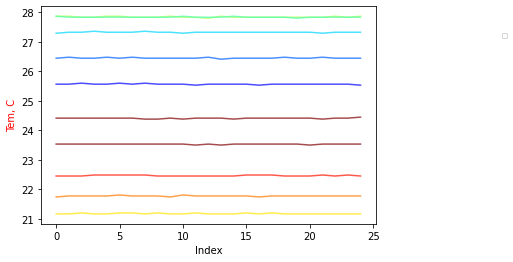

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


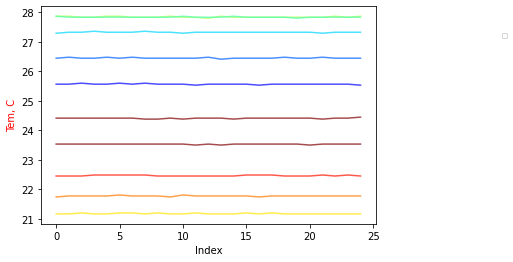

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


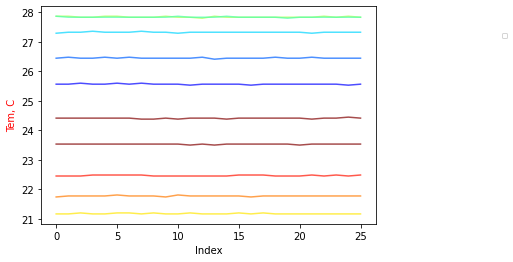

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


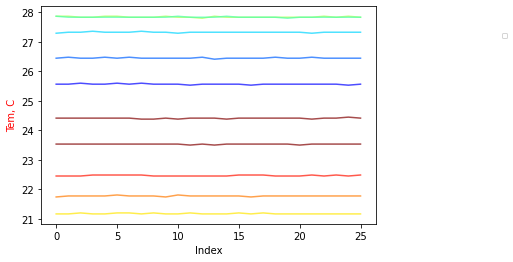

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


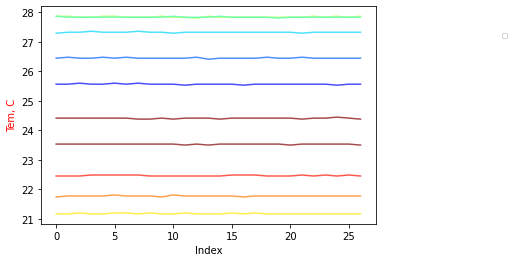

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


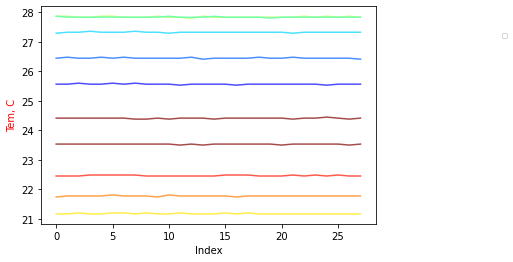

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


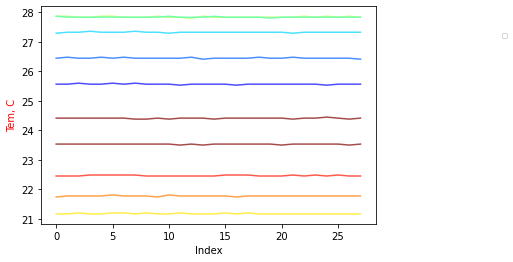

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


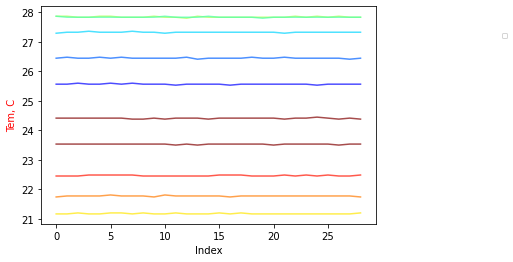

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


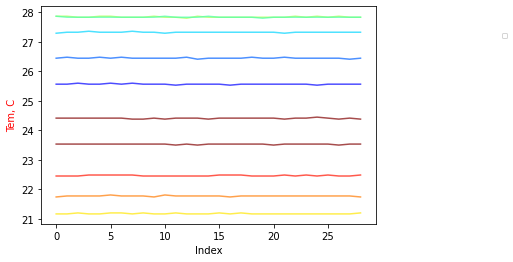

________________________________________________________________
flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


No handles with labels found to put in legend.


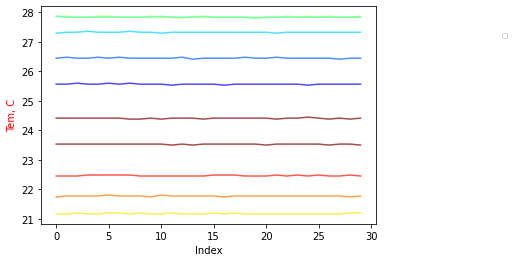

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


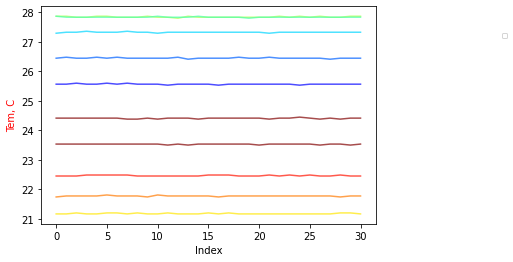

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544


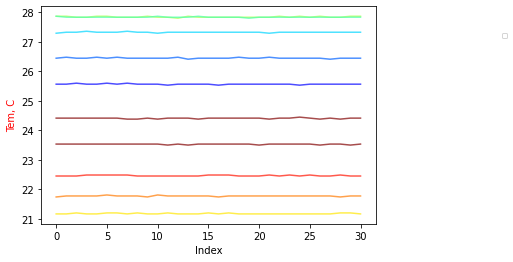

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


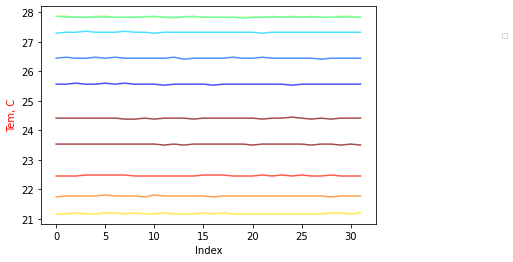

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238


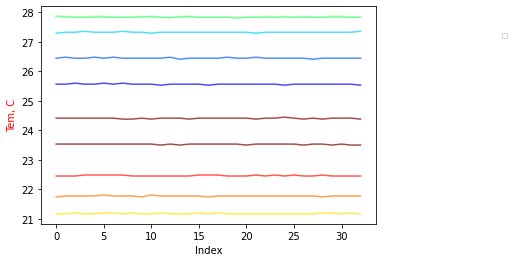

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


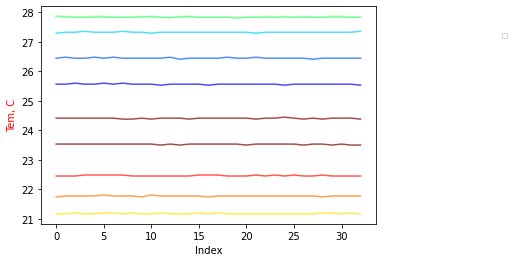

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


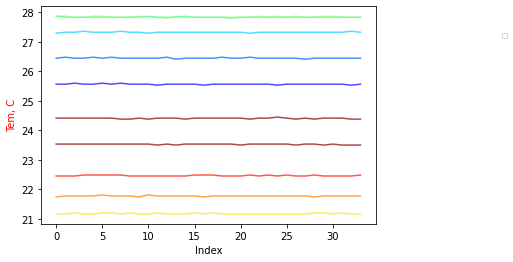

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069


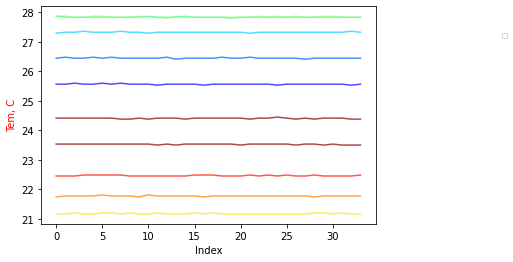

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


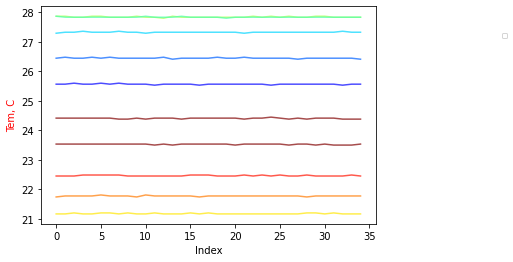

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


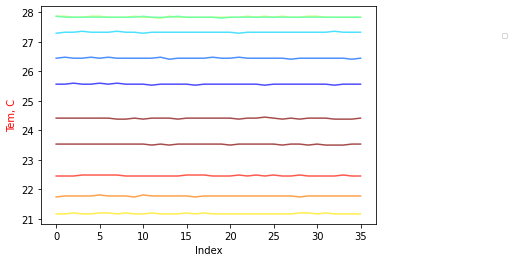

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


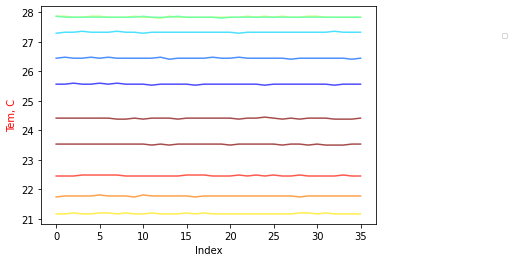

________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


No handles with labels found to put in legend.


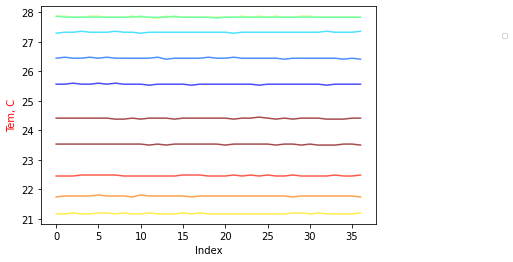

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069


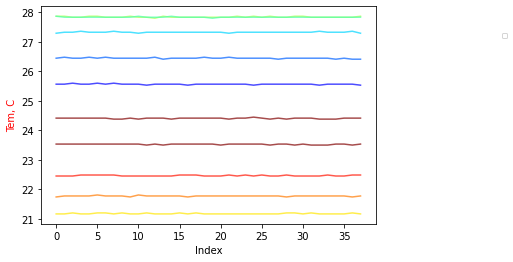

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6300192266609699 0.003946252594180832 -5.187740468238238


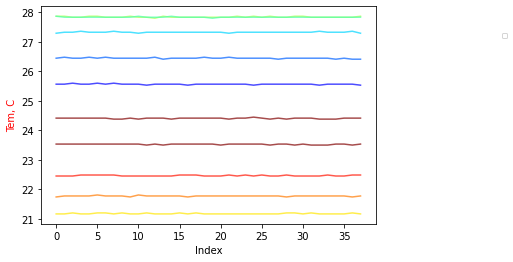

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


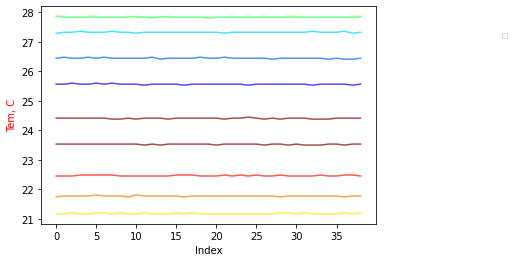

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544


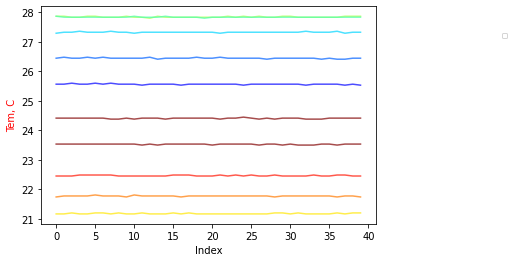

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544


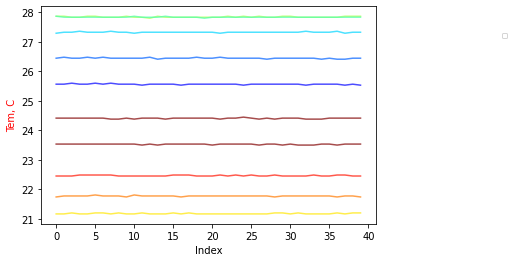

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


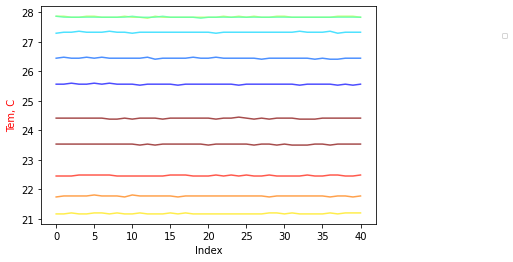

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


No handles with labels found to put in legend.


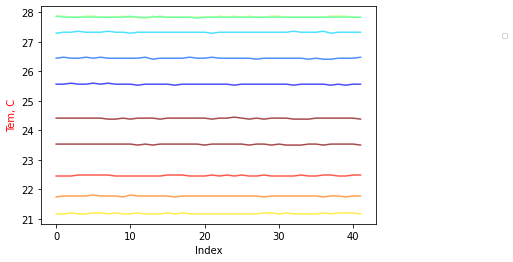

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


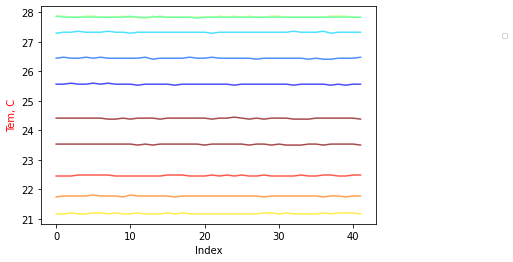

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


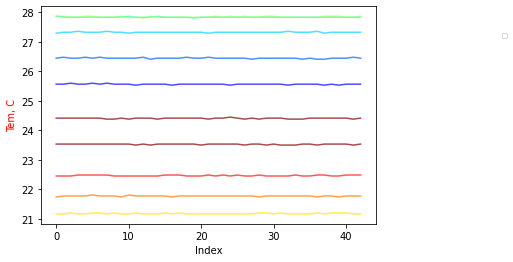

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


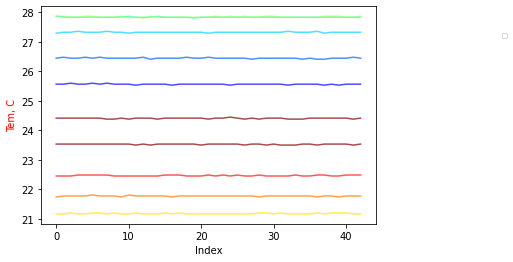

________________________________________________________________
flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


No handles with labels found to put in legend.


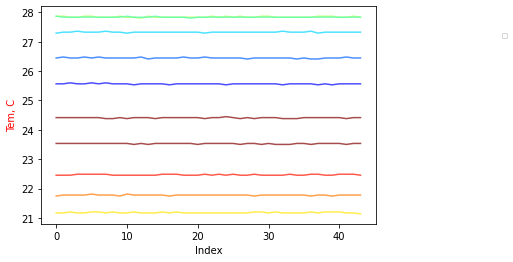

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544


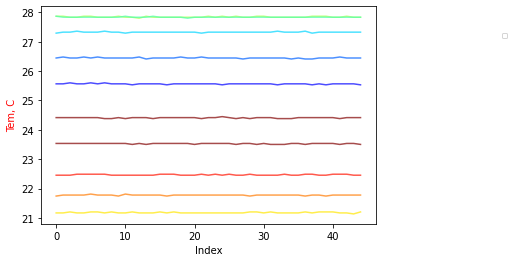

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


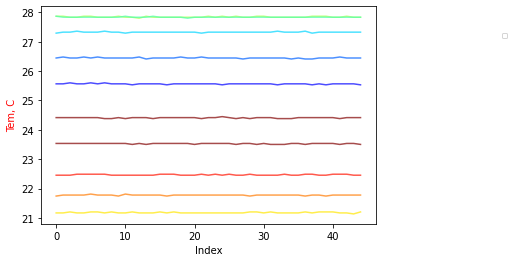

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


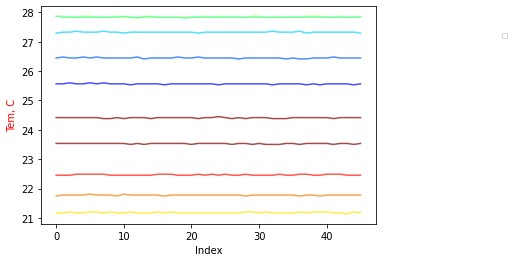

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


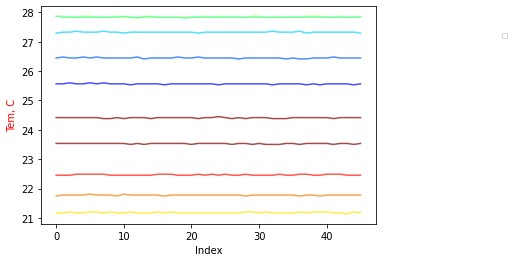

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


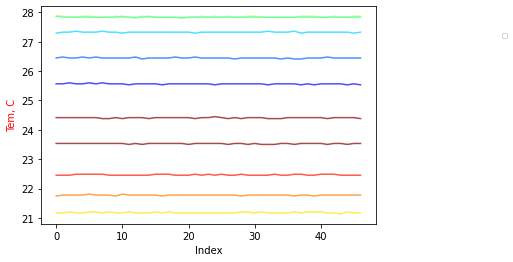

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544


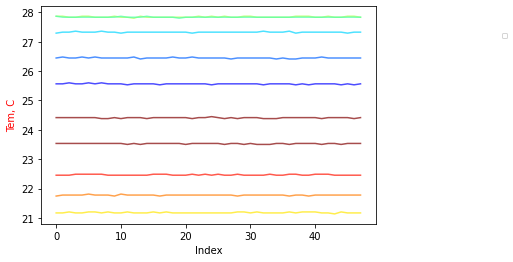

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


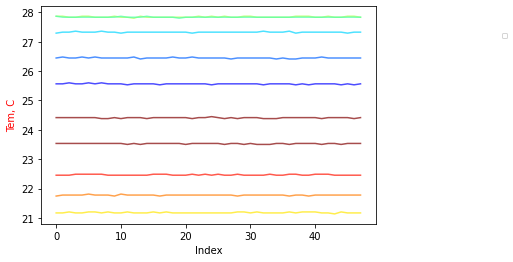

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6360194097720268 0.003989583551449171 2.1121730471176354
flow rates HP is =  0.6380194708090458 0.003996363738233922 4.260273039056376


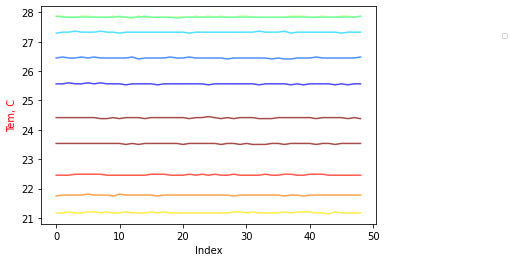

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


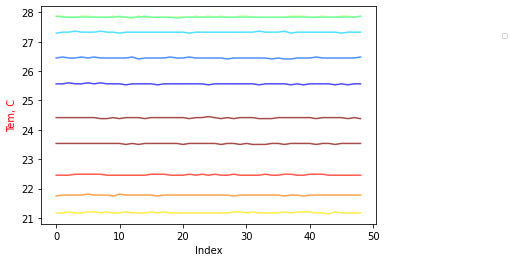

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


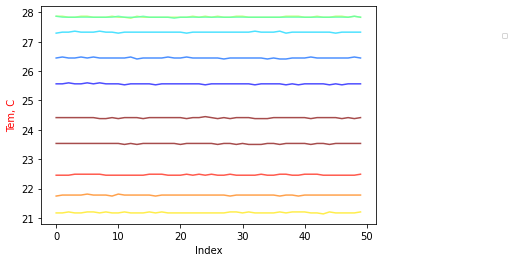

________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544


No handles with labels found to put in legend.


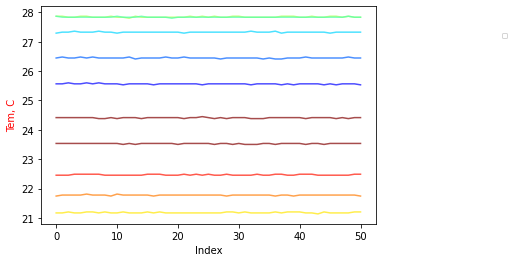

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544


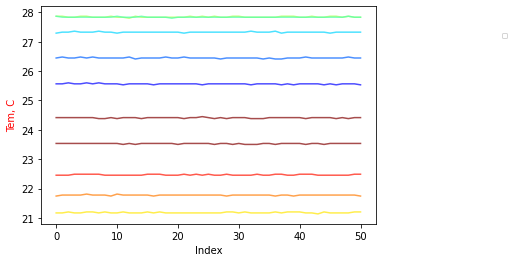

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


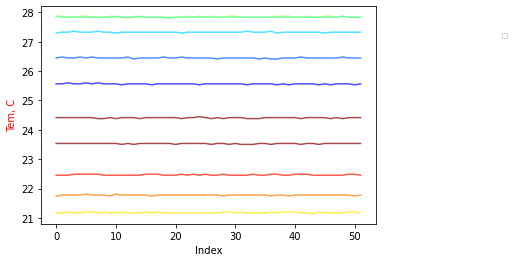

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


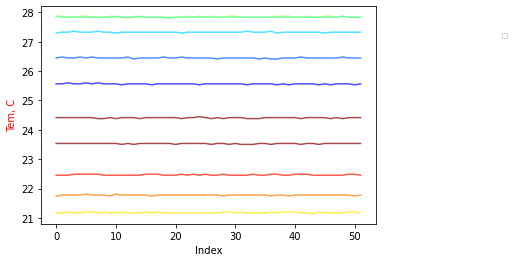

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6280191656239509 0.003939400110550439 -1.0440182043749497
flow rates HP is =  0.6320192876979889 0.003958780380194105 -2.825737091414544


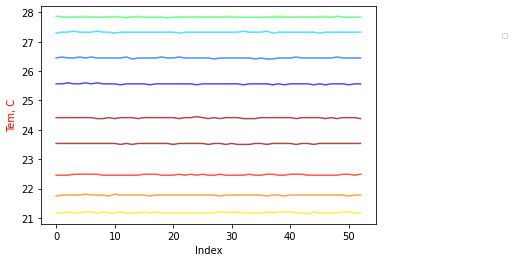

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


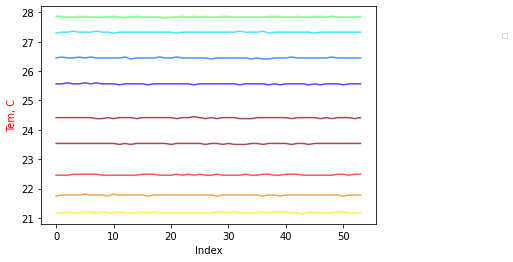

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6380194708090458 0.004002129411673854 2.9012208599907954
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


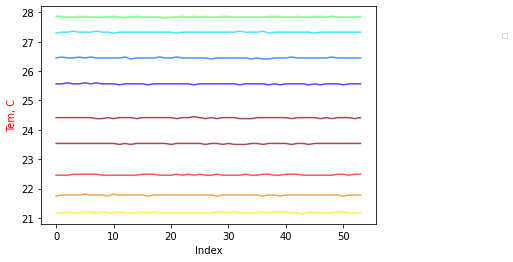

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6300192266609699 0.003951945970775122 -0.25497039150178974
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


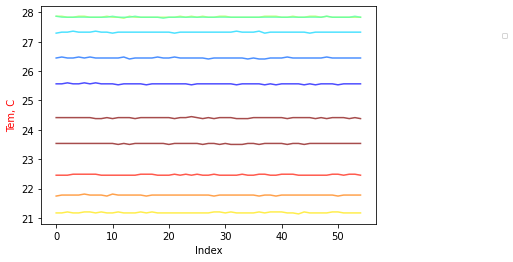

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6400195318460646 0.004008891524247195 6.622276415880069


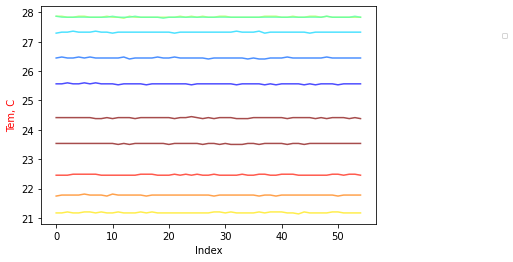

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


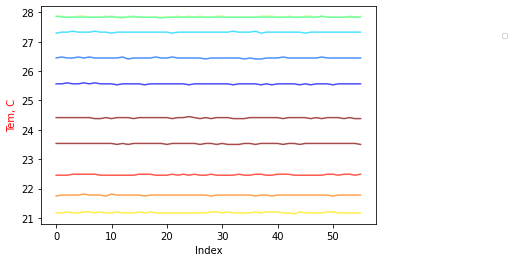

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


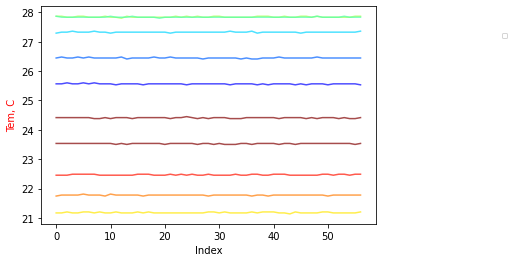

________________________________________________________________
flow rates load is =  0.6320192876979889 0.003964491830999805 0.5340774213713702
flow rates HP is =  0.6360194097720268 0.003983835952220649 1.898269662232681


No handles with labels found to put in legend.


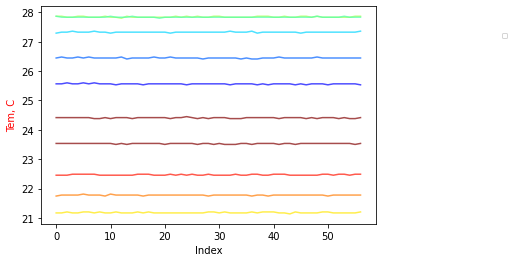

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


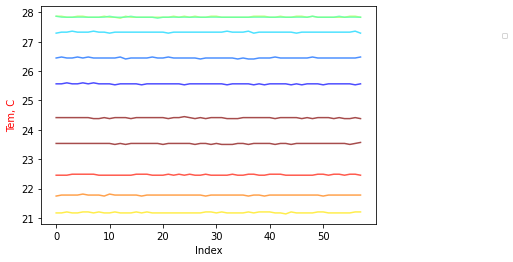

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


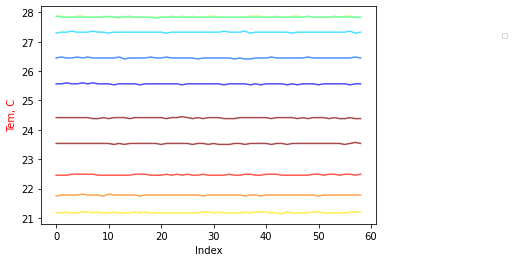

________________________________________________________________


No handles with labels found to put in legend.


flow rates load is =  0.6340193487350078 0.0039770376912244875 1.3231252342444757
flow rates HP is =  0.6340193487350078 0.003971308166207377 -0.4637337145910134


In [ ]:
def plotObject(df,alpha =0.7):
    cmap_name = "jet"
    scm = create_color_step_obj(cmap_name, 10)
    plt.ion()
    fig, ax = plt.subplots()
    #fig, ax = plt.ion()
    ax.set_xlabel('Index')
    ax.set_ylabel('Tem, C', color='r')
    plt.legend (bbox_to_anchor=(1.4,0.89), fontsize='xx-small', loc='upper right', ncol=2)
    for i in range (0, 10):
        fig = ax.plot(df.index, df.iloc[:, i], label = 'Layer ' + str(10-i), color= scm.to_rgba(10-i, alpha))
    plt.show()
    return fig

def plotInnerFig(figs, df):
    for fi in figs:
        fi.set_ydata(df)
        plt.draw()
        plt.pause(0.5)
        plt.show()
    return 
'''
def plot(df, fig):
    for i in range(0, 10):
        x = df.index
        y = df
        plotInnerFig(fig, df)
        
        #plt.draw()
        #plt.pause(0.5)
        #plt.show()
    return
'''

def plot(df, fig):
    x = df.index
    y = df
    Fig = [fi.set_ydata(df) for fi in fig]
        
    plt.draw()
    plt.pause(0.5)
    plt.show()
    return Fig

while True:
    #c.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(?,?,?,?)", (chan2.voltage, chan1.voltage))
    #connection.commit()
    chan1 = AnalogIn(ads, ADS.P0)
    chan2 = AnalogIn(ads, ADS.P1)

    chan1Vol = chan1.voltage
    chan1curr = chan1Vol/159.42

    chan2Vol = chan2.voltage
    chan2curr=chan2Vol/159.65
    #flow1 = ((chan1Vol/159.42)*1000 -4)/16*1000
    flow1 = ((chan1Vol/159.42)-0.003956)/0.0000159
    #flow2 = ((chan2Vol/159.65)*1000 -4)/16*4000 +20
    #flow2 = ((chan2Vol/159.65)- 0.0005468893873066417)/1.09561608e-05
    flow2 = ((chan2Vol/159.65)- 0.003973767754877122)/5.3038815e-06
    cL.execute("INSERT INTO flowReadings(flowHp, flowLoad) VALUES(%s, %s)", (flow2, flow1))
    connectionL.commit()
    #print('flow HP:',"{:>5}\t{:>5.3f}".format(chan2.value, chan2.voltage), '\n\n')
    #print('flow load:',"{:>5}\t{:>5.3f}".format(chan1.value, chan1.voltage, '\n\n'))
    print('flow rates load is = ',chan1Vol, chan1curr,flow1 )
    print('flow rates HP is = ',chan2Vol, chan2curr,flow2 )

    connectionR = db.Connection(host=HOST, port=PORT,user=USER, passwd=PASSWORD, db=DB)
    cR = connectionR.cursor()
    #c.execute("SELECT * from temSensor")
    cR.execute("SELECT * FROM temSensor ORDER BY id DESC LIMIT 1")
    result = cR.fetchall()
    id = result[0][0]
    idGenerator(id, l_id)
    #print ('id is :', id)
    flowRateLoad.append(flow1)

    if lol[0] ==[] or id < lol[0][-1][0][0] :
        lol[0].append(result)
        #print (lol)
        lol[1].append(flow1)
        lol[2].append(flow2)
    elif lol[0] != [] and id > lol[0][-1][0][0]:

        lol[0].append(result)
        lol[1].append(flow1)
        lol[2].append(flow2)


    mct(lol)
    #print (lol)
    #dfs(lol)
    #tankStrat(dfs(lol))
    #plot(tankStrat(dfs(lol)), plotObject(tankStrat(dfs(lol))))
    plotObject(tankStrat(dfs(lol)))
    print('________________________________________________________________')
    time.sleep(0.5)

<IPython.core.display.Javascript object>


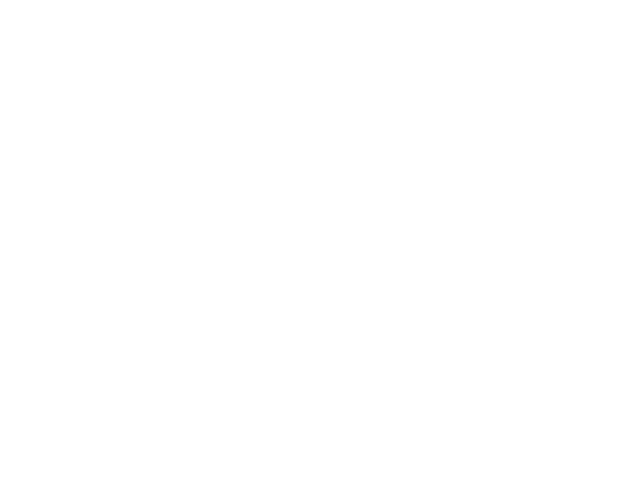

KeyboardInterrupt: 

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as clrs
import matplotlib.cm as cm

# data with 2 columns
X = np.linspace(0,2,1000)
Y1 = X**2 + np.random.random(X.shape)
Y2 = Y1 + 1
Y3 = Y2 + 1
Y4 = Y3 + 1
Y5 = Y4 + 1
df = pd.DataFrame([Y1, Y2, Y3, Y4, Y5]).transpose()
df.columns = ["Y1", "Y2", "Y3", "Y4", "Y5"]

def add_n_rows(df, n):
    X = np.linspace(0, 2, n)
    Y1 = X**2 + np.random.random(X.shape)
    Y2 = Y1 + 1
    Y3 = Y2 + 1
    Y4 = Y3 + 1
    Y5 = Y4 + 1
    new_df = pd.DataFrame([Y1, Y2, Y3, Y4, Y5]).transpose()
    new_df.columns = ["Y1", "Y2", "Y3", "Y4", "Y5"]
    res_df = pd.concat([df, new_df], axis=0)
    res_df.index = range(res_df.shape[0])
    return res_df

def create_color_step_obj(cmap_name, n):
    """
    Return scalarMap object with n colors in gradient from color map
    given in cmap_name.
    """
    cmap = plt.get_cmap(cmap_name)
    values = range(n)
    cNorm  = clrs.Normalize(vmin=values[0], vmax=values[-1])
    scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    return scalarMap

# update function
def plotObject(df, ax, fig, alpha =0.7, scm=None):
    ax.clear()
    for i in range (0, df.shape[1]):
        ax.plot(df.index, df.iloc[:, i], 
                # label = 'Layer ' + str(df.shape[1]-i), 
                color= scm.to_rgba(df.shape[1]-i, alpha=alpha))
    fig.canvas.draw()
    return fig, ax


# colors
cmap_name = "jet"
scm = create_color_step_obj(cmap_name, df.shape[1])

# initialize figure and interactivity
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

# initialize canvas
fig.show()
fig.canvas.draw()

# set labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Tem, C', color='r')
# plt.legend (bbox_to_anchor=(1.4,0.89), fontsize='xx-small', loc='upper right', ncol=2)

while True:
    df = add_n_rows(df, 2)
    fig, ax = plotObject(df, ax, fig, alpha=0.7, scm=scm)
